In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import gamspec

In [2]:
bench = gamspec.Spectrum.from_GammaVision(r'E:\Gamut_dev\spectrum_analysis\标准源谱分析\Eu152_Nie\Eu152 230105.Spe')

bench.label = 'Eu-152'

我们在此处实现了各个模拟能谱的导入和可视化，可以看到bench能谱的数值涨落程度极小，峰也很明显，可以作为基准使用。

然后，我们希望导入预定义的管道网（分析流程）。

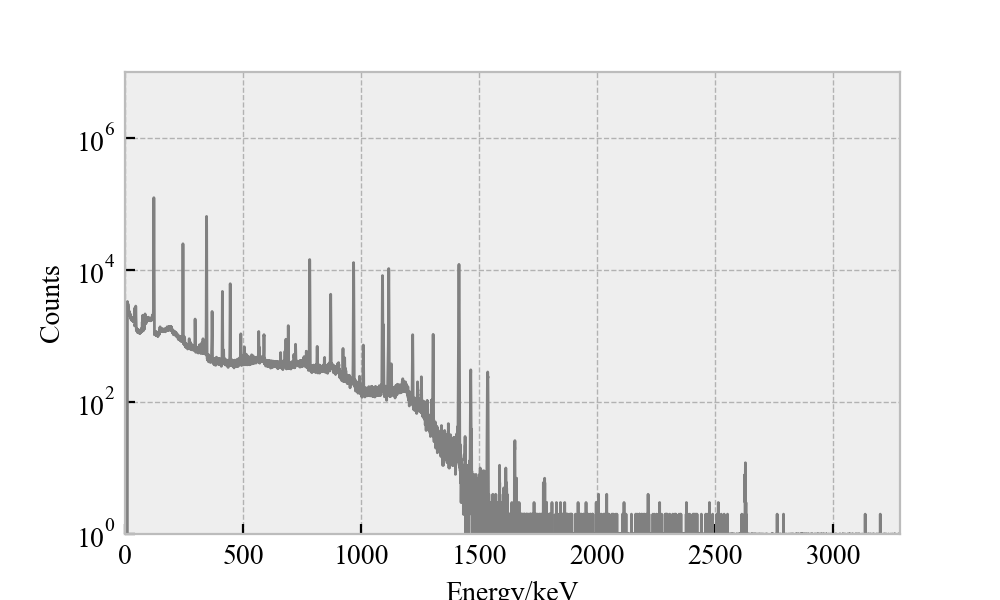

In [3]:
%matplotlib widget
plt.close()

plt.figure(figsize=(5, 3))
bench.plot(linestyle='-', marker='None', markersize=1, color='gray')
plt.yscale('log')
plt.ylim(1, 1E7)

plt.show()

In [4]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher()
# peakfilter = gamspec.PeakSearcher()
convol._min_height_ratio = 0.6
convol._min_height = 100
convol._min_area = 100
convol._min_area_ratio = 2
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._min_height_ratio = 0.6
searcher._min_height = 100
searcher._min_area = 100
searcher._min_area_ratio = 2

def func(spectrum):
    for region in spectrum.regions:
        for peak in region.peaks:
            if 'stderr' not in peak:
                peak['stderr'] = 4
    return spectrum

opr = gamspec.Functionor(func)
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol, searcher, opr]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)

# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1)

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 5, 0)


# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 5, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])
nodes = pipenet([bench])

GAMUT: Start running PipeNet
|Execute: Node 0|[0] >> SavitzkySmoother[O3W7]>>SecondConvolutionSearcher[F20]>>CovarianceSearcher[F4]>>Functionor >> Node 1|[0]
|Execute: Node 0|[0] >> TIWaveletSmoother[O3MqTv] >> Node 1|[1]
|Execute: Node 1|[0, 1] >> Combinor >> Node 2|[0]
|Execute: Node 2|[0] >> AdaptiveSNIPStripper >> Node 5|[0]
|Execute: Node 5|[0] >> RegionPeakFitter >> Node 4|[0]
Fitting Region: 48~123, NPeaks=3, time=Mon Mar 25 16:18:56 2024
Finish Fitting Region: time=Mon Mar 25 16:18:57 2024
Fitting Region: 190~211, NPeaks=1, time=Mon Mar 25 16:18:57 2024
Finish Fitting Region: time=Mon Mar 25 16:18:58 2024
Fitting Region: 219~243, NPeaks=1, time=Mon Mar 25 16:18:58 2024
Finish Fitting Region: time=Mon Mar 25 16:18:58 2024
Fitting Region: 353~385, NPeaks=3, time=Mon Mar 25 16:18:58 2024
Finish Fitting Region: time=Mon Mar 25 16:19:00 2024
Fitting Region: 396~508, NPeaks=3, time=Mon Mar 25 16:19:00 2024
Finish Fitting Region: time=Mon Mar 25 16:19:01 2024
Fitting Region: 589~629, 

e:\Gamut_dev\gamspec\operators\AreaCalculator.py:216: RuntimeWarning: invalid value encountered in matmul
  fcounts[:] = shapes @ heights


Finish Fitting Region: time=Mon Mar 25 16:19:11 2024
Fitting Region: 2044~2100, NPeaks=2, time=Mon Mar 25 16:19:11 2024
LinAlgError: partial_matrix.T @ partial_matrix is not invertible.
Use pseudo-inverse instead
Finish Fitting Region: time=Mon Mar 25 16:19:13 2024
Fitting Region: 2211~2240, NPeaks=1, time=Mon Mar 25 16:19:13 2024
Finish Fitting Region: time=Mon Mar 25 16:19:14 2024
Fitting Region: 2437~2461, NPeaks=1, time=Mon Mar 25 16:19:14 2024
Finish Fitting Region: time=Mon Mar 25 16:19:15 2024
Fitting Region: 2511~2535, NPeaks=1, time=Mon Mar 25 16:19:15 2024
Finish Fitting Region: time=Mon Mar 25 16:19:16 2024
Fitting Region: 2816~2836, NPeaks=1, time=Mon Mar 25 16:19:16 2024
Finish Fitting Region: time=Mon Mar 25 16:19:17 2024
Fitting Region: 2926~2955, NPeaks=1, time=Mon Mar 25 16:19:17 2024
Finish Fitting Region: time=Mon Mar 25 16:19:18 2024
Fitting Region: 3280~3303, NPeaks=1, time=Mon Mar 25 16:19:18 2024
Finish Fitting Region: time=Mon Mar 25 16:19:20 2024
Fitting Region

In [5]:
pipenet.plot()

In [6]:
bench0 = nodes[4][0]
bench0.export_to_pandas()

,left,right,energy,location,height,stderr,area,sig_area2,fitness
0,48,123,10.384257,53,1923.453757,2.341562,11289.567679,760.491168,0.863611
1,48,123,12.187272,62,1829.577109,8.145862,37357.491148,4591.610341,0.863611
2,48,123,17.796652,90,2244.444763,24.008694,135072.639406,23179.362121,0.863611
3,190,211,39.833502,200,1036.835676,2.911660,7567.291435,121.948071,0.959695
4,219,243,45.442882,228,1243.140400,3.470566,10814.600310,196.784635,0.908246
5,353,385,72.688442,364,378.083098,2.888051,2737.046183,244.213858,0.966211
6,353,385,74.691792,374,1.342189,3.069627,10.327361,8973.618115,0.966211
7,353,385,74.892127,375,819.271937,2.396437,4921.347084,9126.623475,0.966211
8,396,508,84.708542,424,555.054234,2.361270,3285.269353,123.773980,0.903906
9,396,508,84.908877,425,209.222337,14.276341,7487.121758,751.837617,0.903906


In [7]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12, 1304.55, 1413.93])
def energy_in_group(energy):
    return np.any(np.abs(energy-energies)<5)
energy_in_group(50)

energy = [121.97 , 245.18 , 345.14 , 368.58 , 412.26 , 445.31 , 691.12 , 781.87 , 870.62 , 967.79 , 1090.19 , 1116.63 , 1218.00 , 1304.55 , 1413.93]
fwhms = [1.21 , 1.29 , 1.37 , 1.58 , 1.42 , 1.42 , 1.62 , 1.65 , 1.69 , 1.77 , 1.82 , 1.86 , 1.92 , 1.96 , 2.04]
plt.plot(energy, fwhms, 'd', color='steelblue', markersize=4, label='Calculated')
fwhmss = [0.000630*erg+ 1.1493 for erg in energy]
plt.plot(energy, fwhmss, label='Fitted', linestyle='--')

plt.xlim(200, 1500)
plt.ylim(1.2, 2)
plt.xlabel('Energy (keV)')
plt.ylabel('FWHM (keV)')
plt.legend(fontsize= 12)

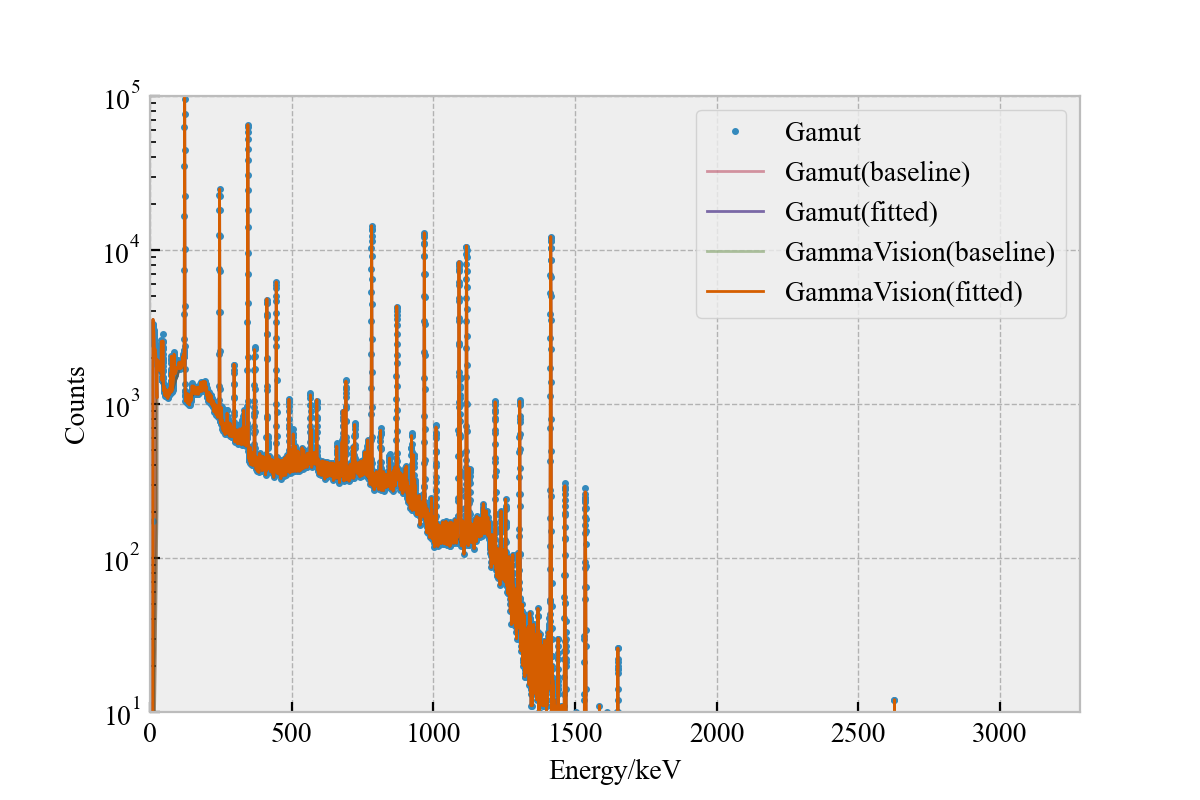

No such comm: d895cd5cfddc4749abab570fa00f8472


In [8]:
'''
Author: albertzhang albert.zhangweij@outlook.com
Date: 2024-01-17 17:40:13
Description: 

Copyright (c) 2024 by THU-RSAG, All Rights Reserved. 
'''
%matplotlib widget
plt.close()
bench.label =  'Gamut'
bench.plot('.')
regions = bench0.regions
bench.regions = regions
baseline = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=True)(bench)
# bench.plot_regions()
bench.plot_peaks(baseline=baseline)

gv_energies = [121.97, 245.18, 345.14, 368.58, 412.26, 445.31, 691.12, 781.87, 870.62, 967.79, 1090.19, 1116.63, 1218.00, 1304.55, 1413.93]
gv_stderrs = [2.310497593, 2.524432555, 2.674187029, 2.738367517, 2.823941502, 2.845334998, 3.294598419, 3.315991915, 3.358778908, 3.57271387, 3.786648833, 3.765255336, 3.91500981, 4.000583795, 4.150338268, ]
gv = bench.copy()
for region in gv.regions:
    for peak in region.peaks:
        for i in range(len(gv_energies)):
            if abs(gv.ergcal(peak['center']) - gv_energies[i]) < 1:
                peak['stderr'] = gv_stderrs[i]
gv.label = 'GammaVision'
gv.plot_peaks(baseline=gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=True)(gv))

# bench0.label = 'final'
# bench0.plot()
# bench0.plot_regions()
# bench0.plot_peaks()


# pipenet.get_node(4)[0].plot()
# pipenet.get_node(4)[0].plot_regions()
# pipenet.get_node(4)[0].plot_peaks()
# spec = pipenet.get_node(3)[0]
# spec.plot()
# spec.plot_regions()
# spec.plot_peaks()

plt.yscale('log')
plt.legend()
plt.ylim(10, 1E5)
# plt.xlim(300, 500)
plt.show()

In [37]:
searcher = gamspec.CovarianceSearcher(5, 3, 'inverse')
searched = searcher(bench.slice((300, 450)))
fit = searched >> gamspec.RegionPeakFitter(3, equal_width=False, baseline=True)

Fitting Region: 66~91, NPeaks=1, time=Mon Mar 25 16:33:10 2024
Finish Fitting Region: time=Mon Mar 25 16:33:10 2024
Fitting Region: 101~110, NPeaks=1, time=Mon Mar 25 16:33:10 2024
Finish Fitting Region: time=Mon Mar 25 16:33:11 2024
Fitting Region: 117~165, NPeaks=2, time=Mon Mar 25 16:33:11 2024
Finish Fitting Region: time=Mon Mar 25 16:33:11 2024
Fitting Region: 179~242, NPeaks=3, time=Mon Mar 25 16:33:11 2024
Finish Fitting Region: time=Mon Mar 25 16:33:12 2024
Fitting Region: 259~277, NPeaks=2, time=Mon Mar 25 16:33:12 2024
Finish Fitting Region: time=Mon Mar 25 16:33:12 2024
Fitting Region: 281~315, NPeaks=3, time=Mon Mar 25 16:33:12 2024
Finish Fitting Region: time=Mon Mar 25 16:33:13 2024
Fitting Region: 325~358, NPeaks=2, time=Mon Mar 25 16:33:13 2024
Finish Fitting Region: time=Mon Mar 25 16:33:13 2024
Fitting Region: 427~472, NPeaks=4, time=Mon Mar 25 16:33:13 2024
Finish Fitting Region: time=Mon Mar 25 16:33:14 2024
Fitting Region: 512~526, NPeaks=1, time=Mon Mar 25 16:33:1

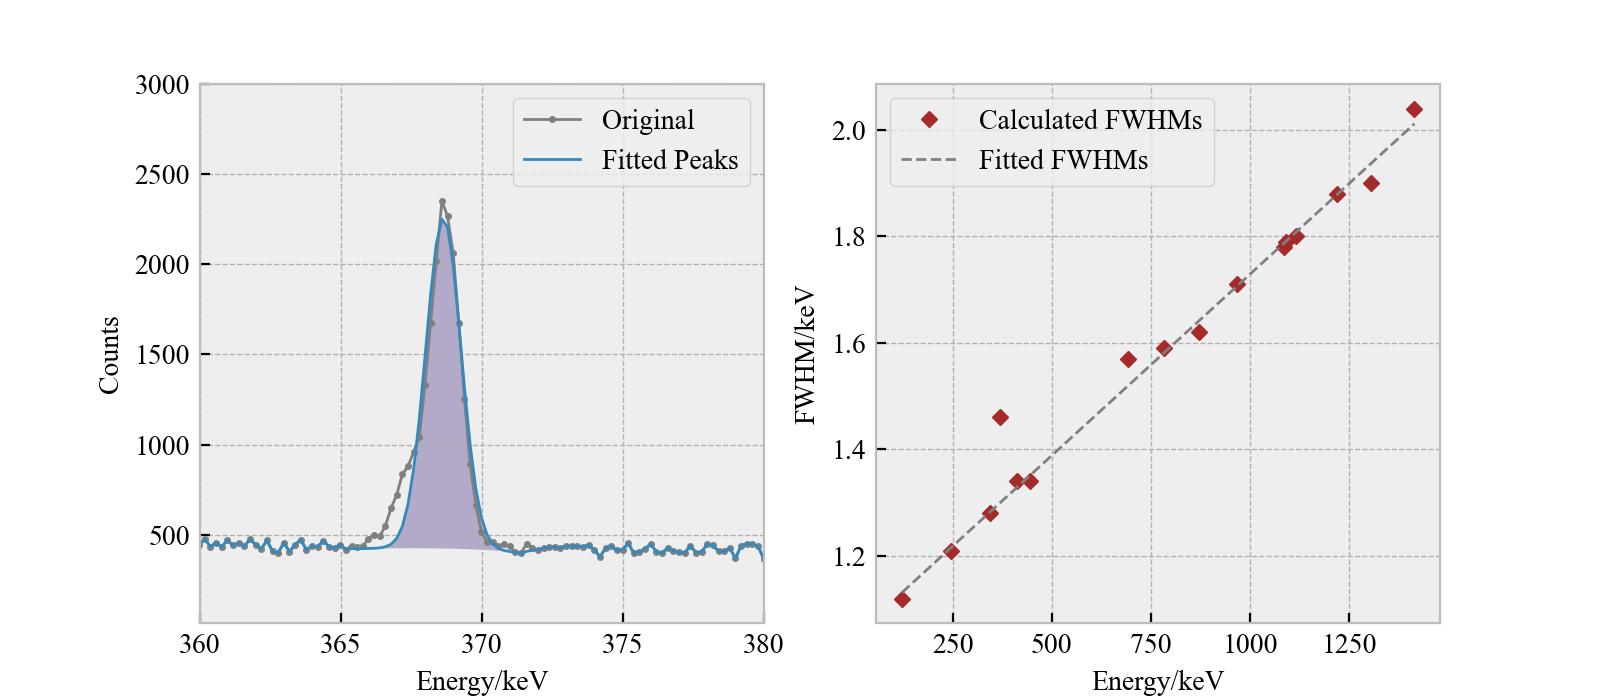

In [59]:
%matplotlib widget
plt.close()

plt.figure(figsize=(8, 3.5))

plt.subplot(121)

bench.label =  'Original'
bench.plot('gray', marker='.')
regions = bench0.regions
bench.regions = regions
# baseline = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=True)(bench)
# bench.plot_regions()

bench.plot_peaks(baseline=baseline, plot_baseline=False, plot_fitted=True, color='brown')
plt.ylim(10, 3E3)
plt.xlim(360, 380)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Original', 'Fitted Peaks'])



plt.subplot(122)

energies = [121.97 , 245.18 , 345.14 , 368.58 , 
            412.26 , 445.31 , 691.12 , 781.87 , 
            870.62 , 967.79 , 1085.19 , 1089.19 , 1116.63 , 
            1218.00 , 1304.55 , 1413.93 , ]
fwhms = [1.12 , 1.21 , 1.28 , 1.46 , 
         1.34 , 1.34 , 1.57 , 1.59 , 
         1.62 , 1.71 , 1.78 , 1.79 , 1.80 , \
             1.88 , 1.90, 2.04]
plt.plot(energies, fwhms, 'D', label='Calculated FWHMs', markersize=4, color='brown')
linear_fit = np.polyfit(energies[:3]+energies[4:], fwhms[:3]+fwhms[4:], 1)
plt.plot(energies, np.polyval(linear_fit, energies), label='Fitted FWHMs', linestyle='--', color='gray')
plt.xlabel('Energy/keV')
plt.ylabel('FWHM/keV')
# plt.yscale('log')
plt.legend()

plt.show()